### Requirments/Setup
This analysis uses pymc3 to complete the bayesian analysis as well as some custom packages for visiualization and several pacakges that are found in the anaconda distribution.

To install pymc3, type: 
```
conda install -c conda-forge pymc3
```

and to install the remaining needed packages:
```
conda install seaborn tqdm
```

Some of the data needs to be "cleaned" as well -- some of the raw `.csv` files have quotes marks (") around them as well. The script `clean_mid_raw.py` removes these and regenerates the files.


In [2]:
%matplotlib inline
import theano
theano.config.floatX = 'float64'
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import pandas as pd
from glob import glob
from tqdm import tqdm_notebook

# Introduction:

The analysis is based somewhat on the LATER model (Noorani, 2016), the general idea of which is that the reciprocal reaction times, $1/\text{RT}$ is normally distributed. To this end, I've turned the analysis into a regression model and ignored some of the subtlty of the LATER model for simplicity.

Let the recipriocal reaction time, $\tau$, be noramly distributed as a function of a linear combination of relevant predictors and coefficencts:

$$ \tau = \frac{1}{\text{RT}} $$


$$ \bar\tau_j \sim \mathcal{N}\left (\bar\beta_{j}X_j, \sigma_{j} \right ) $$

where $X_j$ is the matrix of predictors for subject $j$, $\beta_j$ are the regression coefficients and $\sigma_j$ is the variance of subject $j$. 
So far, this is a standard regression model but we want to introduce a hierachy over the subjects to constrain the parameter estimates. The simplest way to do so is to assume that each of the parameters for a single subject are indpendent of each other (for example, $\beta_{ij}$ is independent of $\sigma_j$), but the same parameter across subjects belong to some distribution (for example $\sigma$ for one subject belongs to the same distribution as $\sigma$ for another subject.

he hierachy was assume is that all of the regression coeffecicents, $\beta_i$, are normally distributed with their own mean and variance:

$$ \beta_{i} \sim \mathcal{N}\left (\mu_i, \sigma_i\right ) $$

we set a low-information prior over $\mu_i$ and $\sigma_i$ of the normal distributions:

$$ p(\mu_i) = \mathcal{N}\left (0, 100\right) $$

$$ p(\sigma_i) = \text{Half-Cauchy}\left (100 \right ) $$

The prior over the mean of the distribution is centered at zero and is very wide, and the Half-Cauchy distribution is restricted to be positive, wide and is generally a good prior in a hierachical model (Gelman, 2006). Each regression coefficient has its hierarchical distribution and the parameter $\mu$ can be interpreted as a group level effect.\\

The variance term of the regression model is also assumed to be hierachical, where each subject's variance $\sigma$ is distributed:

$$ \sigma_j \sim \text{Half-Cauchy}\left (\gamma \right ) $$

where $\gamma$ is the scale parameter for the group. Like in the case of the scale parameters for the normal distributions of the regression coefficients, we use a low information prior over $\gamma$ as well:

$$ p(\gamma) = \text{Half-Cauchy}\left (100 \right ) $$

This is all estimated using pymc3 (Salvatier, 2016) and is pretty straightforward to implement. We find the means using variational inference and then estiamte the posterior with PYMC3 using the No-U-Turn sampler (Hoffman, 2014).

In [19]:
def get_subj_num(filename):
    f = open(filename, 'r')
    header = f.readline()
    f.close()
    return int(header[header.find('ID:')+4:header.find('\tTask type')])

def prep_data(filename):
    subj_num = get_subj_num(filename)
    df = pd.read_csv(filename, delimiter='\t', header=1)
    df = df[~pd.isnull(df.Trial)]
    
    df.columns = df.columns.str.strip()
    df = df.drop(df.columns[df.columns.str.find('Unna')>-1], 1) # drop extraneous columns

    # calculate RT and code by side (left: 0, right: 1)
    df['response'] = (df['Response Made by Subject'].str.find('Right') > -1).astype(int)
    df['rt'] = (df.loc[:, 'Response time'] - df.loc[:, 'Target Phase Start Time']) * 10e-4
    df = df[~pd.isnull(df.rt)] # remove trials with no response

    # get the pavlovian bias terms (need prev correct as well as nuisence regressor)
    df['prev_correct'] = np.concatenate([[0], np.array(df.Outcome == 'SUCCESS', dtype=int)[:-1]])
    df['prev_reward'] = np.concatenate([[0], np.array(df.Amount>0, dtype=int)[:-1]])

    df['subj_idx'] = [subj_num] * len(df)
    df['trial_type'] = df['Trial Category']
    df['target_duration'] = df['Target Phase Duration'] * 10e-4
    
    # Code the target direction (as well as possible, this is a guess)
    df['stim'] = ['N/A'] * len(df)
    R = (df['Response Made by Subject'].str.find('Left') == 0) & (df['Outcome']=="Failure") | \
        (df['Response Made by Subject'].str.find('Right') == 0 & (df['Outcome']=="Success")) | \
        (df['Response Made by Subject'].str.find('Right') > 0)
    L = (df['Response Made by Subject'].str.find('Right') == 0) & (df['Outcome']=="Failure") | \
        (df['Response Made by Subject'].str.find('Left') == 0 & (df['Outcome']=="Success")) | \
        (df['Response Made by Subject'].str.find('Left') > 0)
    df.loc[R, 'stim'] = 'R'
    df.loc[L, 'stim'] = 'L'
    df['subj_idx'] = [subj_num] * len(df)
#     if sum(df['rt'] > 0) == 0:
#         print df
#         raise
    df = df[df['rt'] > 0] # restrict sample to valid trials
    
    return df[
        ['stim', 'rt', 'trial_type', 'target_duration', 
         'prev_correct', 'prev_reward', 'subj_idx']
    ]


files = glob('/Users/nickfranklin/Projects/imagen_data/preprocessed/MID_BL_behavioraldata/mid_*.csv')
subj_list = pd.read_csv('./midt_train_subjects_list.csv').Subject.values
subj_list.sort()

all_data = []
for ii, f in tqdm_notebook(enumerate(files)):
    if get_subj_num(f) in subj_list:
        all_data.append(prep_data(f))

In [20]:
group_data = {
    'y': [], # reciprocal RT
    'x_sd': [], #side 
    'x_tg': [], # reciprocal target time 
    'sub_id': [],
    'x_rw': [],
    'x_hr': [],
    'x_lr': [],
    'x_prev_rew': [],
    'trial_category': [],
    'x_prev_cor': [],
}

t = 0
for ii, d in enumerate(all_data):
    if d.shape[0] > 0:
        group_data['sub_id'] += [t] * d.shape[0]
        group_data['y'] += list(1 / np.array(d['rt']))
        group_data['x_sd'] += np.array(d.stim.str.find('L') == 0, dtype=int).tolist()
        group_data['x_tg'] += list(1 / np.array(d['target_duration']) - \
                                   np.mean(1 / np.array(d['target_duration'])))
        group_data['x_rw'] += np.array(d.trial_type.str.find('NO_WIN') == 0, dtype=int).tolist()
        group_data['x_lr'] += np.array(
            d.trial_type.str.find('SMALL_WIN') > -1, dtype=int).tolist()
        group_data['x_hr'] += np.array(d.trial_type.str.find('BIG_WIN') > -1, dtype=int).tolist()
        group_data['x_prev_cor'] += d.prev_correct.tolist()
        group_data['x_prev_rew'] += d.prev_reward.tolist()
        group_data['trial_category'] += d.trial_type.tolist()
        t += 1
group_data = pd.DataFrame(group_data)
n_subj = len(set(group_data.sub_id))

In [21]:
print "Subject's Requested: %d" % len(subj_list)
print "Subject's In dataset: %d" % n_subj

Subject's Requested: 396
Subject's In dataset: 354


# Cumulative Density Function of Reciprocal RTs

/Users/nickfranklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


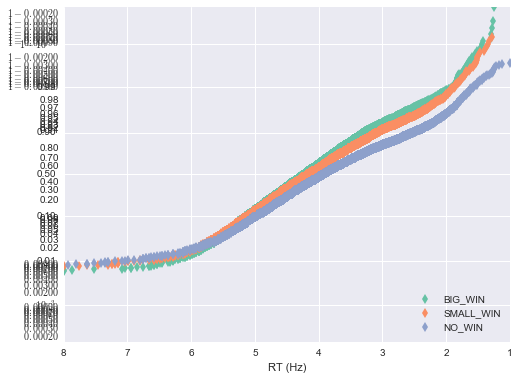

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
cc = sns.color_palette("Set2")
summary = list()
for label, color in zip('BIG_WIN SMALL_WIN NO_WIN'.split(), cc):
    
    x = group_data.loc[group_data.trial_category==label, 'y']
    x = x[~np.isnan(x)]
    x.sort()
    x = np.flipud(x)
    y = np.cumsum(np.ones(len(x)) / len(x))
    plt.plot(x, y, 'd', color=color, label=label)

ax.set_xlim(8, 1)
plt.legend(loc='lower right')
ax.set_yscale('logit')
ax.set_xlabel('RT (Hz)')
plt.show()


# Define Hierachical Models

In [23]:
subj_idx = group_data['sub_id'].values
x_tg = group_data.x_tg.values
x_sd = group_data.x_sd.values
x_rw = group_data.x_rw.values
x_lr = group_data.x_lr.values
x_hr = group_data.x_hr.values
x_pc = group_data.x_prev_cor.values
x_pr = group_data.x_prev_rew.values

# Model 1 (no target duration as predictor)
with pm.Model() as hierarchical_model_1:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    
    mu_b_sd = pm.Normal('mu_beta_left_side', mu=0., sd=100**2)
    sigma_b_sd = pm.Uniform('sigma_beta_left_side', lower=0, upper=100)
    
    mu_b_lr = pm.Normal('mu_beta_low_reward', mu=0., sd=100**2)
    sigma_b_lr = pm.Uniform('sigma_beta_low_reward', lower=0, upper=100)
    
    mu_b_hr = pm.Normal('mu_beta_high_reward', mu=0., sd=100**2)
    sigma_b_hr = pm.Uniform('sigma_beta_high_reward', lower=0, upper=100)
    
    # Intercept for each subject, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_subj).
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subjects, distributed around group mean mu_a
    b_sd = pm.Normal('beta_left_side', mu=mu_b_sd, sd=sigma_b_sd, shape=n_subj)
    b_lr = pm.Normal('beta_low_reward', mu=mu_b_lr, sd=sigma_b_lr, shape=n_subj)
    b_hr = pm.Normal('beta_high_reward', mu=mu_b_hr, sd=sigma_b_hr, shape=n_subj)

    # Model error
    stdev = pm.Uniform('eps', lower=0, upper=100, shape=n_subj)
    stdev_all = stdev[subj_idx] 


    # Regression Model
    y_hat = a[subj_idx] +  b_sd[subj_idx] * x_sd + b_lr[subj_idx] * x_lr + \
            b_hr[subj_idx] * x_hr
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev_all, observed=group_data.y.values)

# Model 2
with pm.Model() as hierarchical_model_2:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    
    mu_b_tg = pm.Normal('mu_beta_target_dur', mu=0., sd=100**2)
    sigma_b_tg = pm.Uniform('sigma_beta_target_dur', lower=0, upper=100)
    
    mu_b_sd = pm.Normal('mu_beta_left_side', mu=0., sd=100**2)
    sigma_b_sd = pm.Uniform('sigma_beta_left_side', lower=0, upper=100)
    
    mu_b_lr = pm.Normal('mu_beta_low_reward', mu=0., sd=100**2)
    sigma_b_lr = pm.Uniform('sigma_beta_low_reward', lower=0, upper=100)
    
    mu_b_hr = pm.Normal('mu_beta_high_reward', mu=0., sd=100**2)
    sigma_b_hr = pm.Uniform('sigma_beta_high_reward', lower=0, upper=100)
    
    # Intercept for each subject, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_subj).
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subjects, distributed around group mean mu_a
    b_tg = pm.Normal('beta_target_dur', mu=mu_b_tg, sd=sigma_b_tg, shape=n_subj)
    b_sd = pm.Normal('beta_left_side', mu=mu_b_sd, sd=sigma_b_sd, shape=n_subj)
    b_lr = pm.Normal('beta_low_reward', mu=mu_b_lr, sd=sigma_b_lr, shape=n_subj)
    b_hr = pm.Normal('beta_high_reward', mu=mu_b_hr, sd=sigma_b_hr, shape=n_subj)

    # Model error
    stdev = pm.Uniform('eps', lower=0, upper=100, shape=n_subj)
    stdev_all = stdev[subj_idx] 


    # Regression Model
    y_hat = a[subj_idx] + b_tg[subj_idx] * x_tg + b_sd[subj_idx] * x_sd + \
            b_lr[subj_idx] * x_lr + b_hr[subj_idx] * x_hr
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev_all, observed=group_data.y.values)
    
# Model 3, same as model 2 but with (reward / high rew) vs (low rew / high rew)
with pm.Model() as hierarchical_model_3:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    
    mu_b_sd = pm.Normal('mu_beta_left_side', mu=0., sd=100**2)
    sigma_b_sd = pm.Uniform('sigma_beta_left_side', lower=0, upper=100)
    
    mu_b_rw = pm.Normal('mu_beta_rewarded', mu=0., sd=100**2)
    sigma_b_rw = pm.Uniform('sigma_beta_rewarded', lower=0, upper=100)
    
    mu_b_hr = pm.Normal('mu_beta_high_reward', mu=0., sd=100**2)
    sigma_b_hr = pm.Uniform('sigma_beta_high_reward', lower=0, upper=100)
    
    # Intercept for each subject, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_subj).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subjects, distributed around group mean mu_a
    b_sd = pm.Normal('beta_left_side', mu=mu_b_sd, sd=sigma_b_sd, shape=n_subj)
    b_rw = pm.Normal('beta_rewarded', mu=mu_b_rw, sd=sigma_b_rw, shape=n_subj)
    b_hr = pm.Normal('beta_high_reward', mu=mu_b_hr, sd=sigma_b_hr, shape=n_subj)

    # Model error
    stdev = pm.Uniform('eps', lower=0, upper=100, shape=n_subj)
    stdev_all = stdev[subj_idx] 


    # Regression Model
    y_hat = a[subj_idx] +  b_sd[subj_idx] * x_sd + b_rw[subj_idx] * x_rw + \
            b_hr[subj_idx] * x_hr
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev_all, observed=group_data.y.values)
    
# Model 4 -- m2 + sequential effects
with pm.Model() as hierarchical_model_4:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    
    mu_b_sd = pm.Normal('mu_beta_left_side', mu=0., sd=100**2)
    sigma_b_sd = pm.Uniform('sigma_beta_left_side', lower=0, upper=100)
    
    mu_b_lr = pm.Normal('mu_beta_low_reward', mu=0., sd=100**2)
    sigma_b_lr = pm.Uniform('sigma_beta_low_reward', lower=0, upper=100)
    
    mu_b_hr = pm.Normal('mu_beta_high_reward', mu=0., sd=100**2)
    sigma_b_hr = pm.Uniform('sigma_beta_high_reward', lower=0, upper=100)
    
    mu_b_pc = pm.Normal('mu_beta_prev_corr', mu=0., sd=100**2)
    sigma_b_pc = pm.Uniform('sigma_beta_prev_corr', lower=0, upper=100)
    
    mu_b_pr = pm.Normal('mu_beta_prev_rew', mu=0., sd=100**2)
    sigma_b_pr = pm.Uniform('sigma_beta_prev_rew', lower=0, upper=100)
    
    # Intercept for each subject, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_subj).
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subjects, distributed around group mean mu_a
    b_sd = pm.Normal('beta_sd', mu=mu_b_sd, sd=sigma_b_sd, shape=n_subj)
    b_lr = pm.Normal('beta_low_reward', mu=mu_b_lr, sd=sigma_b_lr, shape=n_subj)
    b_hr = pm.Normal('beta_high_reward', mu=mu_b_hr, sd=sigma_b_hr, shape=n_subj)
    b_pc = pm.Normal('beta_prev_correct', mu=mu_b_pc, sd=sigma_b_pc, shape=n_subj)
    b_pr = pm.Normal('beta_prev_reward', mu=mu_b_pr, sd=sigma_b_pr, shape=n_subj)

    # Model error
    stdev = pm.Uniform('eps', lower=0, upper=100, shape=n_subj)
    stdev_all = stdev[subj_idx] 

    # Regression Model
    y_hat = a[subj_idx] + b_sd[subj_idx] * x_sd + b_lr[subj_idx] * x_lr + \
            b_hr[subj_idx] * x_hr + b_pc[subj_idx] * x_pc + b_pr[subj_idx] * x_pr
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev_all, observed=group_data.y.values)
    
# Model 5, same as above w/o prev correct
with pm.Model() as hierarchical_model_5:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    
    mu_b_sd = pm.Normal('mu_beta_left_side', mu=0., sd=100**2)
    sigma_b_sd = pm.Uniform('sigma_beta_left_side', lower=0, upper=100)
    
    mu_b_lr = pm.Normal('mu_beta_low_reward', mu=0., sd=100**2)
    sigma_b_lr = pm.Uniform('sigma_beta_low_reward', lower=0, upper=100)
    
    mu_b_hr = pm.Normal('mu_beta_high_reward', mu=0., sd=100**2)
    sigma_b_hr = pm.Uniform('sigma_beta_high_reward', lower=0, upper=100)
    
    mu_b_pr = pm.Normal('mu_beta_prev_rew', mu=0., sd=100**2)
    sigma_b_pr = pm.Uniform('sigma_beta_prev_rew', lower=0, upper=100)
    
    # Intercept for each subject, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_subj).
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subjects, distributed around group mean mu_a
    b_sd = pm.Normal('beta_sd', mu=mu_b_sd, sd=sigma_b_sd, shape=n_subj)
    b_lr = pm.Normal('beta_low_reward', mu=mu_b_lr, sd=sigma_b_lr, shape=n_subj)
    b_hr = pm.Normal('beta_high_reward', mu=mu_b_hr, sd=sigma_b_hr, shape=n_subj)
    b_pr = pm.Normal('beta_prev_reward', mu=mu_b_pr, sd=sigma_b_pr, shape=n_subj)

    # Model error
    stdev = pm.Uniform('eps', lower=0, upper=100, shape=n_subj)
    stdev_all = stdev[subj_idx] 

    # Regression Model
    y_hat = a[subj_idx] + b_sd[subj_idx] * x_sd + b_lr[subj_idx] * x_lr + \
            b_hr[subj_idx] * x_hr + b_pr[subj_idx] * x_pr
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev_all, observed=group_data.y.values)
    
# Model 6, Same as model 2, but with Half-Cauchy prior on the scale parameters
with pm.Model() as hierarchical_model_6:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=100)
    
    mu_b_tg = pm.Normal('mu_beta_target_dur', mu=0., sd=100**2)
    sigma_b_tg = pm.HalfCauchy('sigma_beta_target_dur', beta=100)
    
    mu_b_sd = pm.Normal('mu_beta_left_side', mu=0., sd=100**2)
    sigma_b_sd = pm.HalfCauchy('sigma_beta_left_side', beta=100)
    
    mu_b_lr = pm.Normal('mu_beta_low_reward', mu=0., sd=100**2)
    sigma_b_lr = pm.HalfCauchy('sigma_beta_low_reward', beta=100)
    
    mu_b_hr = pm.Normal('mu_beta_high_reward', mu=0., sd=100**2)
    sigma_b_hr = pm.HalfCauchy('sigma_beta_high_reward', beta=100)
    
    # Intercept for each subject, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_subj).
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subjects, distributed around group mean mu_a
    b_tg = pm.Normal('beta_target_dur', mu=mu_b_tg, sd=sigma_b_tg, shape=n_subj)
    b_sd = pm.Normal('beta_left_side', mu=mu_b_sd, sd=sigma_b_sd, shape=n_subj)
    b_lr = pm.Normal('beta_low_reward', mu=mu_b_lr, sd=sigma_b_lr, shape=n_subj)
    b_hr = pm.Normal('beta_high_reward', mu=mu_b_hr, sd=sigma_b_hr, shape=n_subj)

    # Model error
    stdev = pm.HalfCauchy('eps', beta=100, shape=n_subj)
    stdev_all = stdev[subj_idx] 

    # Regression Model
    y_hat = a[subj_idx] + b_tg[subj_idx] * x_tg + b_sd[subj_idx] * x_sd + \
            b_lr[subj_idx] * x_lr + b_hr[subj_idx] * x_hr
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev_all, observed=group_data.y.values)
    
# Model 7, Same as model 6, but with heirachical scale
with pm.Model() as hierarchical_model_7:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=100)
    
    mu_b_tg = pm.Normal('mu_beta_target_dur', mu=0., sd=100**2)
    sigma_b_tg = pm.HalfCauchy('sigma_beta_target_dur', beta=100)
    
    mu_b_sd = pm.Normal('mu_beta_left_side', mu=0., sd=100**2)
    sigma_b_sd = pm.HalfCauchy('sigma_beta_left_side', beta=100)
    
    mu_b_lr = pm.Normal('mu_beta_low_reward', mu=0., sd=100**2)
    sigma_b_lr = pm.HalfCauchy('sigma_beta_low_reward', beta=100)
    
    mu_b_hr = pm.Normal('mu_beta_high_reward', mu=0., sd=100**2)
    sigma_b_hr = pm.HalfCauchy('sigma_beta_high_reward', beta=100)
    
    # Hyperprior for each subjects' scale parameter
    scale_stdev = pm.HalfCauchy('scale_stdev', beta=100)


    # Intercept for each subject, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_subj).
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subjects, distributed around group mean mu_a
    b_tg = pm.Normal('beta_target_dur', mu=mu_b_tg, sd=sigma_b_tg, shape=n_subj)
    b_sd = pm.Normal('beta_left_side', mu=mu_b_sd, sd=sigma_b_sd, shape=n_subj)
    b_lr = pm.Normal('beta_low_reward', mu=mu_b_lr, sd=sigma_b_lr, shape=n_subj)
    b_hr = pm.Normal('beta_high_reward', mu=mu_b_hr, sd=sigma_b_hr, shape=n_subj)

    # Model error
    stdev = pm.HalfCauchy('eps', beta=scale_stdev, shape=n_subj)
    stdev_all = stdev[subj_idx] 

    # Regression Model
    y_hat = a[subj_idx] + b_tg[subj_idx] * x_tg + b_sd[subj_idx] * x_sd + \
            b_lr[subj_idx] * x_lr + b_hr[subj_idx] * x_hr
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev_all, observed=group_data.y.values)
    
# Model 8, guess at best model?
with pm.Model() as hierarchical_model_8:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=100)
    
    mu_b_tg = pm.Normal('mu_beta_target_dur', mu=0., sd=100**2)
    sigma_b_tg = pm.HalfCauchy('sigma_beta_target_dur', beta=100)
    
    mu_b_sd = pm.Normal('mu_beta_left_side', mu=0., sd=100**2)
    sigma_b_sd = pm.HalfCauchy('sigma_beta_left_side', beta=100)
    
    mu_b_rw = pm.Normal('mu_beta_reward', mu=0., sd=100**2)
    sigma_b_rw = pm.HalfCauchy('sigma_beta_reward', beta=100)
    
    mu_b_hr = pm.Normal('mu_beta_high_reward', mu=0., sd=100**2)
    sigma_b_hr = pm.HalfCauchy('sigma_beta_high_reward', beta=100)
    
    mu_b_pr = pm.Normal('mu_beta_prev_rew', mu=0., sd=100**2)
    sigma_b_pr = pm.HalfCauchy('sigma_beta_prev_rew', beta=100)
    
    # Hyperprior for each subjects' scale parameter
    scale_stdev = pm.HalfCauchy('scale_stdev', beta=100)

    # Intercept for each subject, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_subj).
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subjects, distributed around group mean mu_a
    b_tg = pm.Normal('beta_target_dur', mu=mu_b_tg, sd=sigma_b_tg, shape=n_subj)
    b_sd = pm.Normal('beta_left_side', mu=mu_b_sd, sd=sigma_b_sd, shape=n_subj)
    b_rw = pm.Normal('beta_reward', mu=mu_b_rw, sd=sigma_b_rw, shape=n_subj)
    b_hr = pm.Normal('beta_high_reward', mu=mu_b_hr, sd=sigma_b_hr, shape=n_subj)
    b_pr = pm.Normal('beta_previous_reward', mu=mu_b_pr, sd=sigma_b_pr, shape=n_subj)

    # Model error
    stdev = pm.HalfCauchy('eps', beta=scale_stdev, shape=n_subj)
    stdev_all = stdev[subj_idx] 

    # Regression Model
    y_hat = a[subj_idx] + b_tg[subj_idx] * x_tg + b_sd[subj_idx] * x_sd + \
            b_rw[subj_idx] * x_rw + b_hr[subj_idx] * x_hr + b_pr[subj_idx] * x_pr
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev_all, observed=group_data.y.values)
    
    
# Model 8, guess 2
with pm.Model() as hierarchical_model_9:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=100)
    
    mu_b_tg = pm.Normal('mu_beta_target_dur', mu=0., sd=100**2)
    sigma_b_tg = pm.HalfCauchy('sigma_beta_target_dur', beta=100)
    
    mu_b_sd = pm.Normal('mu_beta_left_side', mu=0., sd=100**2)
    sigma_b_sd = pm.HalfCauchy('sigma_beta_left_side', beta=100)
    
    mu_b_rw = pm.Normal('mu_beta_reward', mu=0., sd=100**2)
    sigma_b_rw = pm.HalfCauchy('sigma_beta_reward', beta=100)
    
    mu_b_hr = pm.Normal('mu_beta_high_reward', mu=0., sd=100**2)
    sigma_b_hr = pm.HalfCauchy('sigma_beta_high_reward', beta=100)
    
    # Hyperprior for each subjects' scale parameter
    scale_stdev = pm.HalfCauchy('scale_stdev', beta=100)


    # Intercept for each subject, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_subj).
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subjects, distributed around group mean mu_a
    b_tg = pm.Normal('beta_target_dur', mu=mu_b_tg, sd=sigma_b_tg, shape=n_subj)
    b_sd = pm.Normal('beta_left_side', mu=mu_b_sd, sd=sigma_b_sd, shape=n_subj)
    b_rw = pm.Normal('beta_reward', mu=mu_b_rw, sd=sigma_b_rw, shape=n_subj)
    b_hr = pm.Normal('beta_high_reward', mu=mu_b_hr, sd=sigma_b_hr, shape=n_subj)

    # Model error
    stdev = pm.HalfCauchy('eps', beta=scale_stdev, shape=n_subj)
    stdev_all = stdev[subj_idx] 

    # Regression Model
    y_hat = a[subj_idx] + b_tg[subj_idx] * x_tg + b_sd[subj_idx] * x_sd + \
            b_rw[subj_idx] * x_rw + b_hr[subj_idx] * x_hr
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev_all, observed=group_data.y.values)
    
    
# Model 10, guess 3
with pm.Model() as hierarchical_model_10:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=100)
    
    mu_b_tg = pm.Normal('mu_beta_target_dur', mu=0., sd=100**2)
    sigma_b_tg = pm.HalfCauchy('sigma_beta_target_dur', beta=100)
    
    mu_b_sd = pm.Normal('mu_beta_left_side', mu=0., sd=100**2)
    sigma_b_sd = pm.HalfCauchy('sigma_beta_left_side', beta=100)
    
    mu_b_lr = pm.Normal('mu_beta_low_reward', mu=0., sd=100**2)
    sigma_b_lr = pm.HalfCauchy('sigma_beta_low_reward', beta=100)
    
    mu_b_hr = pm.Normal('mu_beta_high_reward', mu=0., sd=100**2)
    sigma_b_hr = pm.HalfCauchy('sigma_beta_high_reward', beta=100)
    
    mu_b_pr = pm.Normal('mu_beta_prev_rew', mu=0., sd=100**2)
    sigma_b_pr = pm.HalfCauchy('sigma_beta_prev_rew', beta=100)
    
    # Hyperprior for each subjects' scale parameter
    scale_stdev = pm.HalfCauchy('scale_stdev', beta=100)

    # Intercept for each subject, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_subj).
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subjects, distributed around group mean mu_a
    b_tg = pm.Normal('beta_target_dur', mu=mu_b_tg, sd=sigma_b_tg, shape=n_subj)
    b_sd = pm.Normal('beta_left_side', mu=mu_b_sd, sd=sigma_b_sd, shape=n_subj)
    b_lr = pm.Normal('beta_low_reward', mu=mu_b_lr, sd=sigma_b_lr, shape=n_subj)
    b_hr = pm.Normal('beta_high_reward', mu=mu_b_hr, sd=sigma_b_hr, shape=n_subj)
    b_pr = pm.Normal('beta_previous_reward', mu=mu_b_pr, sd=sigma_b_pr, shape=n_subj)

    # Model error
    stdev = pm.HalfCauchy('eps', beta=scale_stdev, shape=n_subj)
    stdev_all = stdev[subj_idx] 

    # Regression Model
    y_hat = a[subj_idx] + b_tg[subj_idx] * x_tg + b_sd[subj_idx] * x_sd + \
            b_lr[subj_idx] * x_lr + b_hr[subj_idx] * x_hr + b_pr[subj_idx] * x_pr
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev_all, observed=group_data.y.values)

# Estimate the Models and get DIC and WAIC measures (simple)

In [27]:
def fit_model(model):

    with model:
        means, sds, elbos = pm.variational.advi(n=100000)

    # Inference button (TM)!
    with model:
        #start = pm.find_MAP()
        step = pm.NUTS(scaling=means)
        trace = pm.sample(2500, step, start=means, njobs=3)
        
    return trace

In [13]:
hierarchical_trace_1 = fit_model(hierarchical_model_1)

Iteration 0 [0%]: ELBO = -100133.24
Iteration 10000 [10%]: ELBO = -69418.66
Iteration 20000 [20%]: ELBO = -42384.59
Iteration 30000 [30%]: ELBO = -33531.46
Iteration 40000 [40%]: ELBO = -31891.72
Iteration 50000 [50%]: ELBO = -31659.94
Iteration 60000 [60%]: ELBO = -31850.62
Iteration 70000 [70%]: ELBO = -31580.77
Iteration 80000 [80%]: ELBO = -31637.26
Iteration 90000 [90%]: ELBO = -31639.87
Finished [100%]: ELBO = -31644.85
 [-----------------100%-----------------] 5500 of 5500 complete in 3440.5 sec

In [14]:
hierarchical_trace_2 = fit_model(hierarchical_model_2)

Iteration 0 [0%]: ELBO = -101492.75
Iteration 10000 [10%]: ELBO = -69101.45
Iteration 20000 [20%]: ELBO = -43122.13
Iteration 30000 [30%]: ELBO = -33709.06
Iteration 40000 [40%]: ELBO = -31896.79
Iteration 50000 [50%]: ELBO = -31740.52
Iteration 60000 [60%]: ELBO = -31622.91
Iteration 70000 [70%]: ELBO = -31614.32
Iteration 80000 [80%]: ELBO = -31646.83
Iteration 90000 [90%]: ELBO = -31626.85
Finished [100%]: ELBO = -31642.09
 [-----------------100%-----------------] 5501 of 5500 complete in 2500.4 sec

In [15]:
hierarchical_trace_3 = fit_model(hierarchical_model_3)

Iteration 0 [0%]: ELBO = -100132.41
Iteration 10000 [10%]: ELBO = -69352.98
Iteration 20000 [20%]: ELBO = -43105.89
Iteration 30000 [30%]: ELBO = -33786.09
Iteration 40000 [40%]: ELBO = -31801.52
Iteration 50000 [50%]: ELBO = -31625.79
Iteration 60000 [60%]: ELBO = -31832.94
Iteration 70000 [70%]: ELBO = -31560.8
Iteration 80000 [80%]: ELBO = -31612.51
Iteration 90000 [90%]: ELBO = -31623.86
Finished [100%]: ELBO = -31634.96
 [-----------------100%-----------------] 5501 of 5500 complete in 3305.8 sec

In [16]:
hierarchical_trace_4 = fit_model(hierarchical_model_4)

Iteration 0 [0%]: ELBO = -105159.44
Iteration 10000 [10%]: ELBO = -71241.03
Iteration 20000 [20%]: ELBO = -45878.48
Iteration 30000 [30%]: ELBO = -36502.83
Iteration 40000 [40%]: ELBO = -32702.48
Iteration 50000 [50%]: ELBO = -31939.02
Iteration 60000 [60%]: ELBO = -31724.14
Iteration 70000 [70%]: ELBO = -31720.44
Iteration 80000 [80%]: ELBO = -31787.06
Iteration 90000 [90%]: ELBO = -31730.99
Finished [100%]: ELBO = -31736.57
 [-----------------100%-----------------] 5501 of 5500 complete in 4167.0 sec

In [17]:
hierarchical_trace_5 = fit_model(hierarchical_model_5)

Iteration 0 [0%]: ELBO = -101495.82
Iteration 10000 [10%]: ELBO = -69362.39
Iteration 20000 [20%]: ELBO = -44007.15
Iteration 30000 [30%]: ELBO = -34892.71
Iteration 40000 [40%]: ELBO = -32188.4
Iteration 50000 [50%]: ELBO = -31810.97
Iteration 60000 [60%]: ELBO = -31690.24
Iteration 70000 [70%]: ELBO = -31643.65
Iteration 80000 [80%]: ELBO = -31702.74
Iteration 90000 [90%]: ELBO = -31664.01
Finished [100%]: ELBO = -31684.41
 [-----------------100%-----------------] 5501 of 5500 complete in 3113.6 sec

In [18]:
hierarchical_trace_6 = fit_model(hierarchical_model_6)

Iteration 0 [0%]: ELBO = -117829.43
Iteration 10000 [10%]: ELBO = -65332.38
Iteration 20000 [20%]: ELBO = -41630.41
Iteration 30000 [30%]: ELBO = -33394.23
Iteration 40000 [40%]: ELBO = -31942.68
Iteration 50000 [50%]: ELBO = -31823.22
Iteration 60000 [60%]: ELBO = -31715.17
Iteration 70000 [70%]: ELBO = -31697.77
Iteration 80000 [80%]: ELBO = -31737.06
Iteration 90000 [90%]: ELBO = -31707.72
Finished [100%]: ELBO = -31732.26
 [-----------------100%-----------------] 5501 of 5500 complete in 5303.4 sec

In [19]:
hierarchical_trace_7 = fit_model(hierarchical_model_7)

Iteration 0 [0%]: ELBO = -120666.81
Iteration 10000 [10%]: ELBO = -65754.91
Iteration 20000 [20%]: ELBO = -40471.99
Iteration 30000 [30%]: ELBO = -32075.59
Iteration 40000 [40%]: ELBO = -30700.56
Iteration 50000 [50%]: ELBO = -30551.25
Iteration 60000 [60%]: ELBO = -30466.41
Iteration 70000 [70%]: ELBO = -30451.41
Iteration 80000 [80%]: ELBO = -30502.14
Iteration 90000 [90%]: ELBO = -30463.3
Finished [100%]: ELBO = -30444.43
 [-----------------100%-----------------] 5500 of 5500 complete in 2189.8 sec

In [20]:
hierarchical_trace_8 = fit_model(hierarchical_model_8)

Iteration 0 [0%]: ELBO = -120077.95
Iteration 10000 [10%]: ELBO = -64977.05
Iteration 20000 [20%]: ELBO = -42608.01
Iteration 30000 [30%]: ELBO = -33632.25
Iteration 40000 [40%]: ELBO = -30816.09
Iteration 50000 [50%]: ELBO = -30586.54
Iteration 60000 [60%]: ELBO = -30488.77
Iteration 70000 [70%]: ELBO = -30472.36
Iteration 80000 [80%]: ELBO = -30523.65
Iteration 90000 [90%]: ELBO = -30471.7
Finished [100%]: ELBO = -30532.16
 [-----------------100%-----------------] 5501 of 5500 complete in 4946.4 sec

In [28]:
hierarchical_trace_9 = fit_model(hierarchical_model_9)

100%|██████████| 2500/2500 [59:55<00:00,  1.71it/s]


In [22]:
hierarchical_trace_10 = fit_model(hierarchical_model_10)

Iteration 0 [0%]: ELBO = -120079.81
Iteration 10000 [10%]: ELBO = -64930.57
Iteration 20000 [20%]: ELBO = -41542.84
Iteration 30000 [30%]: ELBO = -33452.56
Iteration 40000 [40%]: ELBO = -31001.23
Iteration 50000 [50%]: ELBO = -30652.59
Iteration 60000 [60%]: ELBO = -30519.04
Iteration 70000 [70%]: ELBO = -30485.42
Iteration 80000 [80%]: ELBO = -30539.73
Iteration 90000 [90%]: ELBO = -30486.23
Finished [100%]: ELBO = -30541.79
 [-----------------100%-----------------] 5501 of 5500 complete in 5579.4 sec

## Model Comparisons
To compare the various models, we evaluate each of their WAIC, which is now aparently a preferred model selection measure over DIC for Bayesian models (Gelman, 2014; Watanabe, 2010). DIC is also shown for comparison.

In [23]:
traces = [hierarchical_trace_1, hierarchical_trace_2, hierarchical_trace_3, 
          hierarchical_trace_4, hierarchical_trace_5, hierarchical_trace_6,
          hierarchical_trace_7, hierarchical_trace_8, hierarchical_trace_9,
          hierarchical_trace_10,
         ]

models = [hierarchical_model_1, hierarchical_model_2, hierarchical_model_3, 
          hierarchical_model_4, hierarchical_model_5, hierarchical_model_6,
          hierarchical_model_7, hierarchical_model_8, hierarchical_model_9,
          hierarchical_model_10,
         ]

fit_statitics = pd.DataFrame(index=['M%d' % ii for ii in range(1, len(models)+1)], 
                             columns=['DIC', 'WAIC'])
fit_statitics.index.name = 'Model'

for ii, (trace, model) in enumerate(zip(traces, models), 1):
    fit_statitics.loc["M%d" % ii, 'DIC'] = pm.stats.dic(model=model, trace=trace[500:])
    fit_statitics.loc["M%d" % ii, 'WAIC'] = pm.stats.waic(model=model, trace=trace[500:])



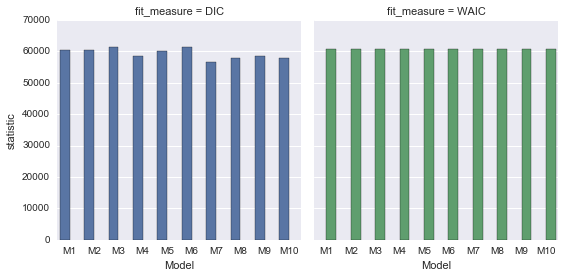

In [24]:
_fit_statitics = pd.melt(fit_statitics.reset_index(), id_vars=['Model'], 
                         var_name='fit_measure', value_name='statistic')

g = sns.factorplot(x='Model', y='statistic', col='fit_measure', hue='fit_measure', 
                   data=_fit_statitics, 
                   kind='bar')


In [25]:
_fit_statitics

,Model,fit_measure,statistic
0,M1,DIC,60553.6
1,M2,DIC,60285.1
2,M3,DIC,61503.1
3,M4,DIC,58448.4
4,M5,DIC,60012.3
5,M6,DIC,61398.4
6,M7,DIC,56696.5
7,M8,DIC,57920.4
8,M9,DIC,58569.8
9,M10,DIC,58034.6


In [28]:
tmp = _fit_statitics[_fit_statitics.fit_measure=='WAIC']
tmp[tmp.statistic==tmp.statistic.min()]

,Model,fit_measure,statistic
18,M9,WAIC,60690.9


# Plot Posteriors for individual subjects
Model 9 was the winning models, so we will plot its posterior

In [29]:
hierarchical_trace_9.varnames

['mu_alpha',
 'sigma_alpha_log_',
 'mu_beta_target_dur',
 'sigma_beta_target_dur_log_',
 'mu_beta_left_side',
 'sigma_beta_left_side_log_',
 'mu_beta_reward',
 'sigma_beta_reward_log_',
 'mu_beta_high_reward',
 'sigma_beta_high_reward_log_',
 'scale_stdev_log_',
 'alpha',
 'beta_target_dur',
 'beta_left_side',
 'beta_reward',
 'beta_high_reward',
 'eps_log_',
 'sigma_alpha',
 'sigma_beta_target_dur',
 'sigma_beta_left_side',
 'sigma_beta_reward',
 'sigma_beta_high_reward',
 'scale_stdev',
 'eps']

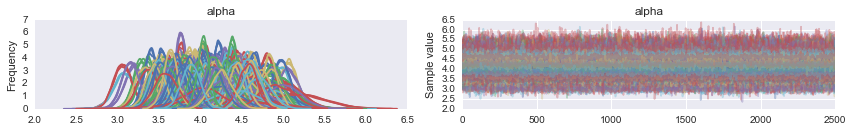

In [35]:
pm.traceplot(hierarchical_trace_9, varnames=['alpha'])
plt.show()

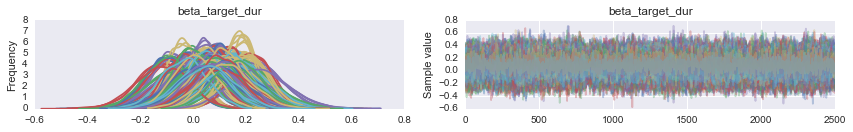

In [36]:
pm.traceplot(hierarchical_trace_9, varnames=['beta_target_dur'])
plt.show()

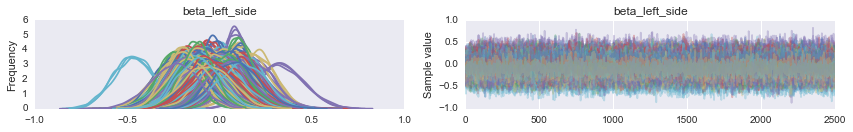

In [37]:
pm.traceplot(hierarchical_trace_9, varnames=['beta_left_side'])
plt.show()

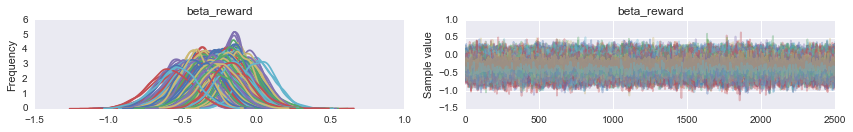

In [38]:
pm.traceplot(hierarchical_trace_9, varnames=['beta_reward'])
plt.show()

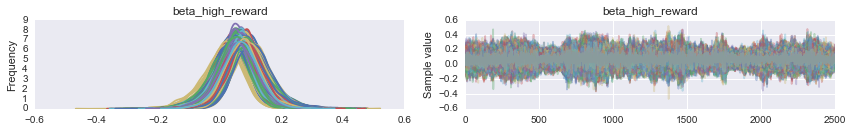

In [39]:
pm.traceplot(hierarchical_trace_9, varnames=['beta_high_reward'])
plt.show()

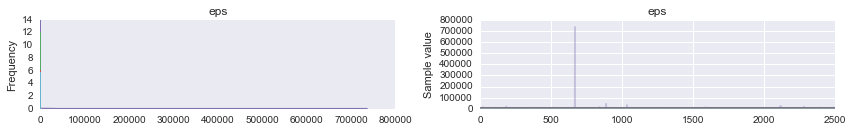

In [40]:
pm.traceplot(hierarchical_trace_9, varnames=['eps'])
plt.show()

# Get Expectation and Variance of each subject parameters of interest

In [54]:
# Get the Expecations for all of the variables and match it to the subjects
t = 0
id_key = {}
for ii, d in enumerate(all_data):
    if d.shape[0] > 0:
        id_key[t] = d.subj_idx.values[0]
        t += 1


In [ ]:
vars_of_interest = ['beta_target_dur', 'beta_left_side', 
                    'beta_low_reward', ## Low reward is misnamed -- it's really just reward
                    'beta_high_reward',
                   'eps',
                   'alpha']

new_parameter_names = {
    'beta_target_dur': 'Target Duration Coeff',
    'beta_left_side': 'Target is Left Coeff',
    'beta_low_reward': 'Cue is Rewarded Coeff',
    'beta_high_reward': 'Cue is High Reward Coeff',
    'eps': 'StDev of 1/RT',
    'alpha': 'Intercept'
}

summary_stats = []
for subj in tqdm_notebook(set(subj_idx)):
    for var in vars_of_interest:
        sample = hierarchical_trace_9.get_values(var)[:, subj]
        sample = sample.reshape(5500, 3)[:500].reshape(1500) # remove burned samples
        summary_stats.append({
                'Subject': id_key[subj],
                'Parameter': new_parameter_names[var],
                'Expectation': np.mean(sample),
                'Variance': np.var(sample)
            })
summary_stats = pd.DataFrame(summary_stats)
summary_stats.to_csv('MIDT_SubjectFits_All.csv')